C:\Users\maksc\AppData\Local\Temp\ipykernel_19832\4017422255.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode()[0]).map({'True': 1, 'False': 0})


Дерево решений (валидация): 0.7504
Случайный лес (валидация): 0.7769


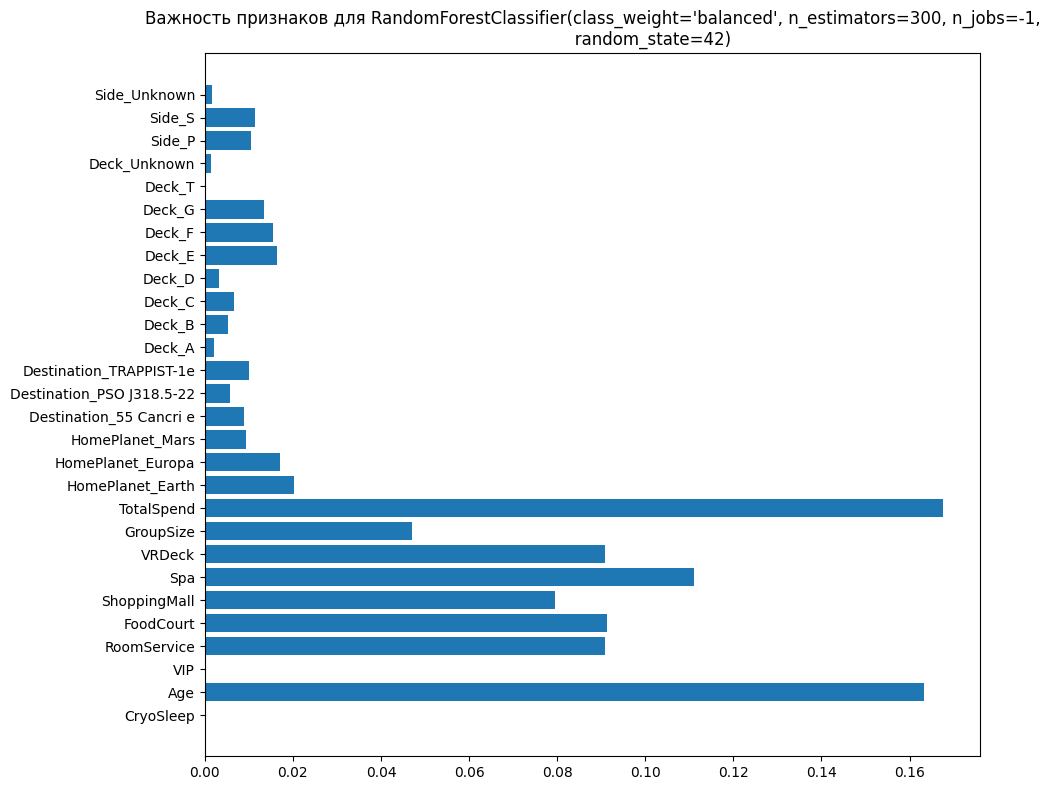

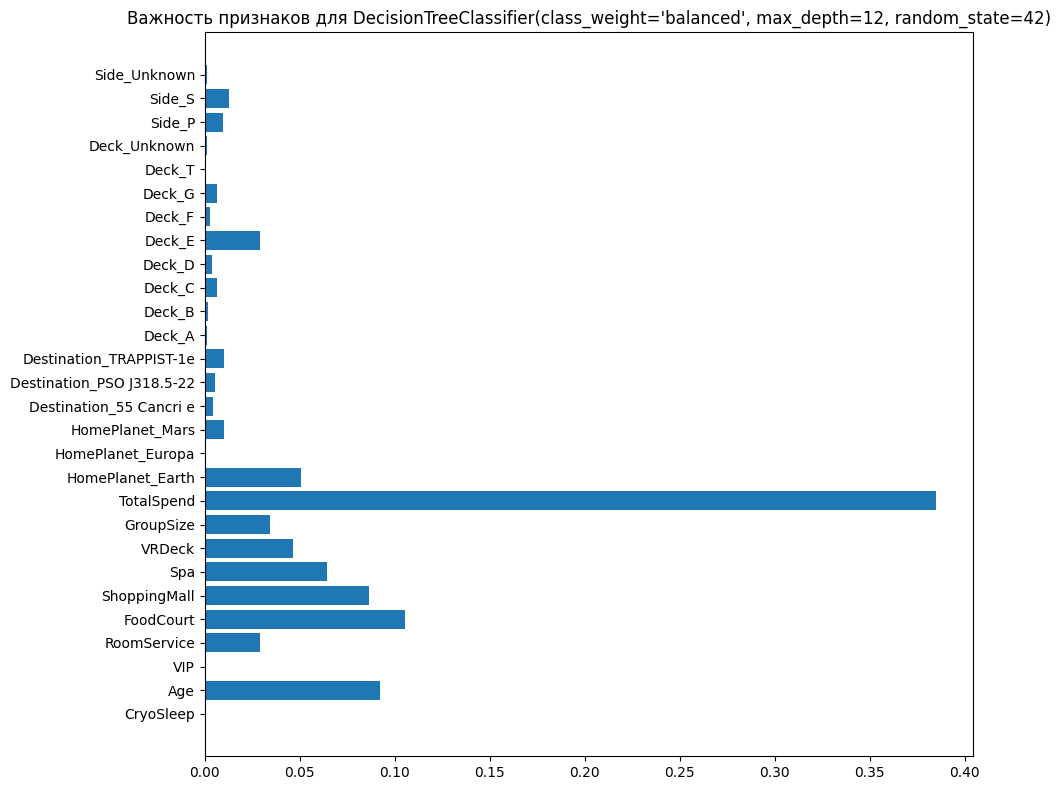

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['is_train'] = 1
test['is_train'] = 0
test['Transported'] = np.nan
df = pd.concat([train, test], axis=0).reset_index(drop=True)

#Feature Engeneering

# 1. Family
# df['LastName'] = df['Name'].str.split().str[-1].fillna('Unknown')
# df['FamilySize'] = df['LastName'].map(df['LastName'].value_counts())

# 2. Group
df['Group'] = df['PassengerId'].str.split('_').str[0]
df['GroupSize'] = df['Group'].map(df['Group'].value_counts())

# 3. Cabin
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
df['Deck'] = df['Deck'].fillna('Unknown')
df['Side'] = df['Side'].fillna('Unknown')
#df['Num'] = pd.to_numeric(df['Num'], errors='coerce').fillna(-1)  
df = df.drop(columns=['Num']) 

# 4. CryoSleep, Vip
df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode()[0]).map({'True': 1, 'False': 0})
df['VIP'] = df['VIP'].fillna(0).astype(int).map({'True': 1, 'False': 0})

# 5. TotalSpend
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df['TotalSpend'] = df[spend_cols].sum(axis=1)

# обработка пропусков
num_cols = ['Age'] + spend_cols + ['TotalSpend', 'GroupSize']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
cat_cols = ['HomePlanet', 'Destination']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df = df.drop(columns=['PassengerId', 'Cabin', 'Name', 'Group'])

#========================================================================
X = df[df['is_train'] == 1].drop(columns=['is_train', 'Transported'])
y = train['Transported'].map({True: 1, False: 0})
X_test_orig = df[df['is_train'] == 0].drop(columns=['is_train', 'Transported'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# one-hot
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test_orig)

X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

dt = DecisionTreeClassifier(
    max_depth=12,
    class_weight='balanced',
    random_state=42
)
dt.fit(X_train, y_train)
dt_val_preds = dt.predict(X_val)
dt_score = accuracy_score(y_val, dt_val_preds)
print(f"Дерево решений (валидация): {dt_score:.4f}")

rf = RandomForestClassifier(
    n_estimators=300,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
rf_val_preds = rf.predict(X_val)
rf_score = accuracy_score(y_val, rf_val_preds)
print(f"Случайный лес (валидация): {rf_score:.4f}")

for i in [rf , dt]:
    plt.figure(figsize=(10, 8))
    plt.barh(X_full.columns.tolist(), i.feature_importances_)
    plt.title(f'Важность признаков для {i}')
    plt.tight_layout()
    plt.show()
